# Survival Analysis Exploration

Adapted this code from the Scikit-Survival documentation here:
 * https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html

Used a different larger test dataset from the package in order to have some different results.

## Imports

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sksurv.datasets import load_flchain
from sksurv.preprocessing import OneHotEncoder
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [80]:
X, y = load_flchain()
X.describe()

,age,creatinine,kappa,lambda
count,7874.000000,6524.000000,7874.000000,7874.000000
mean,64.293117,1.093516,1.430881,1.702624
std,10.462719,0.416507,0.896774,1.030732
min,50.000000,0.400000,0.010000,0.040000
25%,55.000000,0.900000,0.960000,1.200000
50%,63.000000,1.000000,1.270000,1.510000
75%,72.000000,1.200000,1.680000,1.920000
max,101.000000,10.800000,20.500000,26.600000


## Kaplan-Meier Estimator

Text(0.5, 0, 'time $t$')

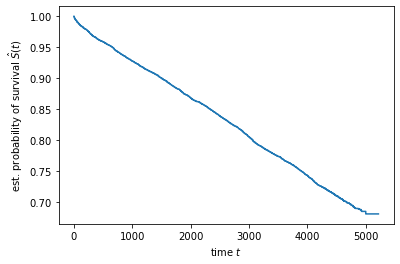

In [68]:
time, survival_prob = kaplan_meier_estimator(y["death"], y["futime"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Fit KM for two different categories in the data.  This code is quite a bit more manual and verbose than how it's implemented in R.  This would be a pain to do for another factor on top of this one.  

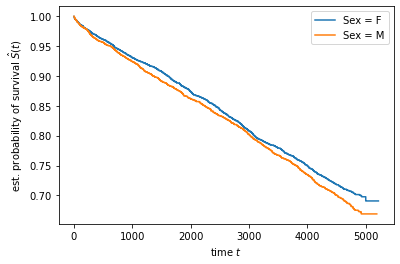

In [69]:
for sex in X.sex.unique():
    filt = X["sex"] == sex
    time, survival_prob = kaplan_meier_estimator(y["death"][filt], y["futime"][filt])
    
    plt.step(time, survival_prob, where="post",
             label="Sex = %s" % sex)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

Prep the data to fix a CPH model.  First need to determine what to do with NA values.  The continuous variable creatinine is missing 1350/7874 values for creatinine.  The discrete variable chapter is missing 5705/7874 values.  Chapter appears to be the ICD cause of death, so it is only populated for records where there was a death.  We can't use this variable for modeling since we only know the cause of death after death happens.

In [122]:
X.isna().sum()

age              0
chapter       5705
creatinine    1350
flc.grp          0
kappa            0
lambda           0
mgus             0
sample.yr        0
sex              0
dtype: int64

For creatinine, we could either exclude the records with missing creatinine or look to impute values of creatinine.  First, I want to understand whether or not there is a difference in survival outcomes for records with missing creatinine vs non-missing creatinine. 

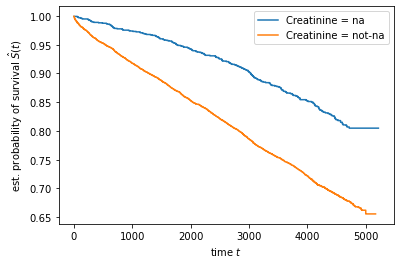

In [123]:
for val in ["na", "not-na"]:
    if val == "na":
        filt = X["creatinine"].isna()
    else: 
        filt = ~X["creatinine"].isna()
    time, survival_prob = kaplan_meier_estimator(y["death"][filt], y["futime"][filt])
    
    plt.step(time, survival_prob, where="post",
             label="Creatinine = %s" % val)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

From the KM analysis, it appears that for missing values of creatinine, survival is significanly higher. This means there is likely a structural reason that creatinine is missing from these records.  For the initial model, I'm going to exclude this variable

In [126]:
X_num = OneHotEncoder().fit_transform(X[['age', 'flc.grp', 'kappa', 'lambda', 'mgus', 'sample.yr', 'sex']])
X.columns

Index(['age', 'chapter', 'creatinine', 'flc.grp', 'kappa', 'lambda', 'mgus',
       'sample.yr', 'sex'],
      dtype='object')

In [127]:
X_num.columns

Index(['age', 'flc.grp=2', 'flc.grp=3', 'flc.grp=4', 'flc.grp=5', 'flc.grp=6',
       'flc.grp=7', 'flc.grp=8', 'flc.grp=9', 'flc.grp=10', 'kappa', 'lambda',
       'mgus=yes', 'sample.yr=1996', 'sample.yr=1997', 'sample.yr=1998',
       'sample.yr=1999', 'sample.yr=2000', 'sample.yr=2001', 'sample.yr=2002',
       'sample.yr=2003', 'sex=M'],
      dtype='object')

In [140]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X_num, y)

CoxPHSurvivalAnalysis()

In [141]:
pd.Series(cph.coef_, index=X_num.columns)


age               0.103709
flc.grp=2        -0.093034
flc.grp=3         0.069239
flc.grp=4         0.074452
flc.grp=5         0.052560
flc.grp=6         0.242050
flc.grp=7         0.133205
flc.grp=8         0.261167
flc.grp=9         0.243430
flc.grp=10        0.560105
kappa             0.023416
lambda            0.155937
mgus=yes          0.089784
sample.yr=1996   -0.046639
sample.yr=1997    0.029358
sample.yr=1998    0.018287
sample.yr=1999    0.040938
sample.yr=2000    0.295787
sample.yr=2001    0.662818
sample.yr=2002   -1.779438
sample.yr=2003   -0.089327
sex=M             0.311122
dtype: float64

0